# Do MLB Players Perform Better In Their Contract Year?

In this notebook, I'll analyze the data set we put together in [data_prep](data_prep.ipynb) notebook. If you have not looked through that notebook yet, please do so!

Here, I am going to test whether MLB players perform better in their "contract year". The question [has been asked before](https://sabr.org/research/do-hitters-boost-their-performance-during-their-contract-years) in [multiple sports](https://www.espn.com/fantasy/football/story/_/id/13248280/nfl-skill-players-overwhelmingly-perform-better-contract-years-fantasy-football), and while my approach is not as sophisticated as some, I do have data updated for last last labor agreement (2012-2016).

In [16]:
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
%run functions.py

Let's start by importing our data prepared in the [data_prep notebook](data_prep.ipynb).

In [17]:
batting_df = pd.read_csv(FILE_LOCS['dataset'], index_col=0)
batting_df.head()

,G,AB,R,H,2B,3B,HR,RBI,SB,CS,...,year_wOBA,year_wOBAScale,wOBA,wRAA,wRC+,wRC+_t-1,is_signed,is_unsigned,is_fa,service_time
abadan01_2006,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.332,1.170,0.283200,-0.208547,62.526106,NaN,True,False,True,NaN
abercre01_2006,111.0,255.0,39.0,54.0,12.0,2.0,5.0,24.0,6.0,5.0,...,0.332,1.170,0.263800,-16.379658,53.701099,NaN,False,False,False,NaN
abercre01_2007,35.0,76.0,16.0,15.0,3.0,0.0,2.0,5.0,7.0,1.0,...,0.331,1.192,0.245262,-5.754195,41.056586,53.701099,False,False,False,NaN
abercre01_2008,34.0,55.0,10.0,17.0,5.0,0.0,2.0,5.0,5.0,2.0,...,0.328,1.211,0.364220,1.794567,121.270452,41.056586,True,False,True,NaN
abreubo01_2006,156.0,548.0,98.0,163.0,41.0,2.0,15.0,107.0,30.0,6.0,...,0.332,1.170,0.387537,32.562645,131.995358,NaN,False,False,False,9.165


Now that we have our data imported, we can do some descriptive statistics to explore our dataset. I am going to start by limiting the time period to the last labor agreement, since player incentives change depending on rules outlined in the  Collective Bargaining Agreement (CBA). By eliminating confounding factors like different CBA rules, we ensure that our results are due to a player's impending free agency and not another variable. 

I am also going to limit myself to players-seasons with at least 502 plate appearances. That might seem like an arbitrary number to some, but it's [MLB's offical number to qualify for a batting title](https://www.baseball-reference.com/bullpen/Qualifier). 

This is going to limit our dataset quite a bit, but we need to keep in mind what the average fan means when they talk about the ["contract year phenomenon"](https://en.wikipedia.org/wiki/Contract_year_phenomenon). We are usually refering to players who have a chance at huge sums of money. Some elite players might still have a shot a big contract even if they get injured, but typically, a player needs to (1) be healthy to recieve a large contract and (2) have a starting position on a team.

Below, I've calculated descriptive statistics and a histogram of the wRC+ for both free agents and everyone else.

In [18]:
min_ABs = batting_df[(batting_df['PA']>=502) &
                     (batting_df['yearID']>=2012) &
                     (batting_df['yearID']<=2016)]
FAs = min_ABs[min_ABs['is_fa']]
everyone_else = min_ABs[~min_ABs['is_fa']]

summarize_dfs(FAs, everyone_else, output_names=['FAs', 'Else'])

,FAs,Else
count,77.000000,639.000000
mean,111.434836,111.892888
std,19.542368,22.842286
min,62.664277,49.659276
25%,95.744898,97.113445
50%,110.195574,110.610681
75%,125.843770,125.586389
max,167.984959,197.559182


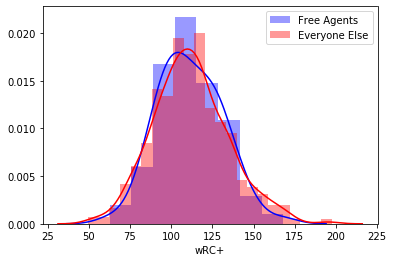

In [19]:
plot_histogram(FAs, everyone_else)

Our two groups look nearly identical, but there are more confounders to consider. For example, we have included players with less than 6 years of [service time](http://m.mlb.com/glossary/transactions/service-time) in the "Everyone Else" group. That means our "Free Agent" group contains more seasoned players.

By removing players with less than 6 years of service time from "Everyone Else", we can ensure that we are comparing like players.

In [20]:
min_st = min_ABs[(min_ABs['PA']>=502)]
FAs = min_st[min_st['is_fa']]
everyone_else = min_st[~min_st['is_fa'] & (min_ABs['service_time']>6)]

summarize_dfs(FAs, everyone_else, output_names=['FAs', 'Else'])

,FAs,Else
count,77.000000,249.000000
mean,111.434836,114.624947
std,19.542368,21.441678
min,62.664277,66.328665
25%,95.744898,100.576564
50%,110.195574,113.407859
75%,125.843770,128.595875
max,167.984959,193.010332


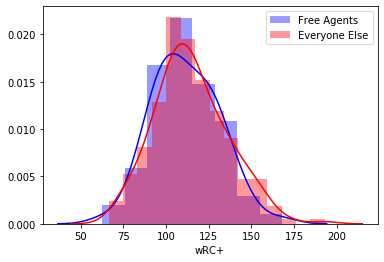

In [21]:
plot_histogram(FAs, everyone_else)

The mean wRC+ for "Everyone Else" jumped a bit, and in that group, our n decreased by over half! It makes intuitive sense that more seasoned players are better, so we should not be suprised by the result.

However, a t-test will confirm whether our groups are statistically different. Our null hypothesis is that these groups are the same. If we run a t-test where the pvalue is below our alpha of 0.05, we could determine that our dependent variable (service time) is truly the reason for the difference (with 95% confidence). Let's try it!

In [22]:
stats.ttest_ind(FAs['wRC+'], everyone_else['wRC+'], equal_var=False)

Ttest_indResult(statistic=-1.2227978827087123, pvalue=0.22350102843717187)

The difference between the two groups is not statistically significant after all, since:

> pvalue: 0.2235 > alpha: 0.05

We can chalk up the wRC+ increase to random chance.

Still, we have a pretty big flaw in our data set. The "is_fa" variable does not capture players that have retired. Retirement is tricky. In some cases, a player's retirment is planned, but some players are forced into retirement due to a performance drop off.

Unfortunately, I do not have a database for player retirements, but I do have dummy variables called "is_signed" and "is_unsigned". In order to ensure we exclude retired players, we can filter by "is_signed", but we will inevitably exclude some players who did not plan to retire.

I am going to make this trade-off in my analysis, but we should keep this in mind when interpret our results.

In [23]:
everyone_else = min_st[~min_st['is_signed'] & 
                       ~min_st['is_unsigned'] &
                       (min_ABs['service_time']>6)]
FAs = min_st[min_st['is_signed']]

summarize_dfs(FAs, everyone_else, output_names=['FAs', 'Else'])

,FAs,Else
count,70.000000,249.000000
mean,112.940056,114.624947
std,19.462865,21.441678
min,62.664277,66.328665
25%,98.694191,100.576564
50%,111.411659,113.407859
75%,126.864842,128.595875
max,167.984959,193.010332


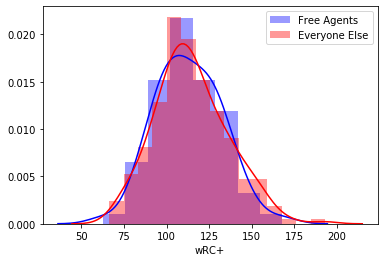

In [24]:
plot_histogram(FAs, everyone_else)

Our groups look even more similar than before, but I'm going to run one last t-test to be sure.

In [25]:
stats.ttest_ind(FAs['wRC+'], everyone_else['wRC+'], equal_var=False)

Ttest_indResult(statistic=-0.6254145324676649, pvalue=0.5328844087857453)

We have only been running t-tests so far, but we can also try a modeling approach. A type of model called a regression will help us explore the relationship between free agency and performance at a deeper level.

In the next cell, I put together a simple three factor multivariate regression. Regressions attempt to model the relationship between an independent variable and one or more dependent variables by solving for a linear equation.

I am going to limit our dataset by:
* Only including player seasons from 2012 to 2016
* Excluding players with less than 6 years of service time
* Excluding players without wRC+ in the previous year (since this will be one of our model factors)

I am going to include the following independent variables:
* Previous years wRC+: This will give the model a baseline for a given player's skill level
* Number of Plate Appearances: We filtered on plate appearances in our data exploration, but here I am going to include it as a variable. I suspect that players who play more have higher wRC+, and as a result, including it in our model will help "explain" our independant variable.
* Our "is_signed" Dummy Variable: This is factor we will pay the most attention to!

Before we set up our regresion, we should be aware of an issue called multicollinearity. If any of our factors are correlated, our regression will not function as expected. I am going to create a correlation matrix of our independent variables in order to ensure that they are relatively uncorrelated.

In [26]:
min_st[['wRC+_t-1', 'PA', 'is_signed']].corr()

,wRC+_t-1,PA,is_signed
wRC+_t-1,1.000000,0.212298,-0.046365
PA,0.212298,1.000000,-0.039928
is_signed,-0.046365,-0.039928,1.000000


These results look good, but we can also check out "Variance Inflation Factor" (VIF) after we run our regression to confirm that we have no multicollinearity if necessary.

Now for our regression:

In [27]:
batting_df_reg = batting_df[(batting_df['yearID']>=2012) &
                            (batting_df['yearID']<=2016) &
                            (batting_df['service_time']>=6) &
                            (~pd.isnull(batting_df['wRC+_t-1']))]

In [28]:
X = batting_df_reg[['wRC+_t-1', 'PA', 'is_signed']]
y = batting_df_reg['wRC+']
X = sm.add_constant(X)
est = sm.OLS(y.astype(float), X.astype(float)).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wRC+   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     154.8
Date:                Sun, 03 Nov 2019   Prob (F-statistic):           1.73e-77
Time:                        20:19:04   Log-Likelihood:                -3432.5
No. Observations:                 727   AIC:                             6873.
Df Residuals:                     723   BIC:                             6891.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.9285      4.454      5.597      0.000      16.185      33.672
wRC+_t-1       0.3256      0.040      8.061      0.000       0.246       0.405
PA             0.0875      0.006     15.054      0.000       0.076       0.099
is_signed      2.8251      2.224      1.270      0.204      -1.541       7.192
==============================================================================
Omnibus:                      276.180   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2694.943
Skew:                          -1.423   Prob(JB):                         0.00
Kurtosis:                      11.993   Cond. No.                     2.17e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

That's a lot of data! First lets look at our R-squared. We can think of R-squared as the ratio of explained variance to total variance. More simply, an R-squared of 0.9 means that 90% of the dependent variable is explained by our independent variables.

Our model has an R-square of only 0.391. That's not up to snuff. It does not necessarily mean our model is bad&#151;it could mean that our model is incomplete and that there might be other independent variables that could explain the wRC+ data.

Scroll down, and let's look at the table of our factors. All three factors have a positive relationship to wRC+ as indicated by the "coef" column. For example, we can expect a 0.0875 wRC+ bump for each plate appearance a player has. Here, is_signed looks good, because it's eigenvalue (the "coef" column) is 2.83. This group of free agents experienced a 2.83 bump in wRC+.

While this might inspire some optimism, the "P>|t|" column throws cold water on the alternative hypothesis that impending free agents play better. This column contains two-tailed p-values. A p-value above 0.05 means that the factor's relationship to wRC+ is not statistically signigicant. Previous wRC+ and plate appearances each have p-values lower than 0.05, indicating that both eigenvalues are statistifcally signicant. However, is_signed p-value is 0.204. We cannot conclude that is_signed has a strong relationship to wRC+.

In conclusion, we cannot say players play better in contract years. Still, more research and data might help us build a model that better predicts wRC+. For example, I made a big assumption about retirements, and we do not account for injuries. 

In the future, I'd like to collect complete service time data. In this analysis I only use it as a dummy variable (True or False) instead of a continuous one (e.g. number of years). I suspect we could improve our model if we used a continous variable as one of our factors.